# Fraud Detection System
#### Project Assignment by Plentica 

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier # Decision tree algorithm
from sklearn.ensemble import RandomForestClassifier # Random forest tree algorithm
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve, auc, precision_score
from xgboost import XGBClassifier # XGBoost algorithm
from random import seed,sample


%matplotlib inline
sns.set_theme(style="darkgrid")


## Importing the data

In [2]:
path = r'C:\Users\Mustafa Minhas\PycharmProjects\CreditFix - Assigment\Plentica\transactions_train.csv'
df = pd.read_csv(path)

In [3]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6351193 entries, 0 to 6351192
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrig  float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 484.6+ MB


In [4]:
df.head(10)

step      type    amount     nameOrig  oldbalanceOrig  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.00       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.00        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.00            0.00   
3     1  CASH_OUT    181.00   C840083671          181.00            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.00        29885.86   
5     1   PAYMENT   7817.71    C90045638        53860.00        46042.29   
6     1   PAYMENT   7107.77   C154988899       183195.00       176087.23   
7     1   PAYMENT   7861.64  C1912850431       176087.23       168225.59   
8     1   PAYMENT   4024.36  C1265012928         2671.00            0.00   
9     1     DEBIT   5337.77   C712410124        41720.00        36382.23   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  
0  M1979787155             0.0            0.00        0  
1  M2044282225             0.0            0.00        0  
2   C553264065             0.0            0.00        1  
3    C38997010         21182.0            0.00        1  
4  M1230701703             0.0            0.00        0  
5   M573487274             0.0            0.00        0  
6   M408069119             0.0            0.00        0  
7   M633326333             0.0            0.00        0  
8  M1176932104             0.0            0.00        0  
9   C195600860         41898.0        40348.79        0

In [5]:
df.size

63511930

In [6]:
df.dropna()
df.size

63511930

What does the columns mean

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.



## Exploratory Data Analysis (EDA) 

In [7]:
### Checking for null values
print('Null Values -', df.isnull().values.any())

Null Values - False


So, no null values 

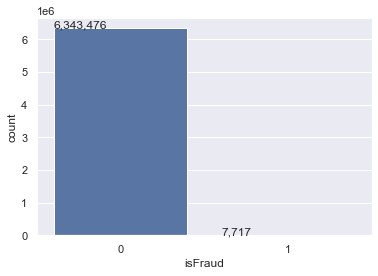

In [8]:
df['isFraud'].value_counts()
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="isFraud", data=df)
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))

In [9]:
import math
a= (8213/(6343476+7177))*100
print ('The percentage of Fraud transactions is ' "%.2f" % a, '%' )

The percentage of Fraud transactions is 0.13 %


### Distribution of the Transaction Type Column 

CASH_OUT    2233369
PAYMENT     2147832
CASH_IN     1396865
TRANSFER     531817
DEBIT         41310
Name: type, dtype: int64


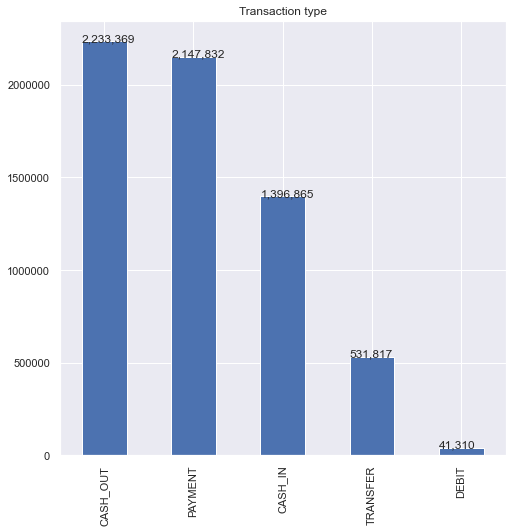

In [10]:
print(df.type.value_counts())
f, ax = plt.subplots(1, 1, figsize=(8, 8))
df.type.value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(8,8))
plt.ticklabel_format(style='plain', axis='y')
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))
plt.show()

Number of transactions that is safe - 6354407 
    

Number of transactions that are Fraud but not Flagged by the system - 8197
   

 Number of transactions that are Fraud and are Flagged bt the system - 16

### Datasets with respect to Transaction types 

#### Payment 

In [11]:
payment_df = df[df["type"] == 'PAYMENT']
payment_df.head(5)

step     type    amount     nameOrig  oldbalanceOrig  newbalanceOrig  \
0     1  PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1  PAYMENT   1864.28  C1666544295         21249.0        19384.72   
4     1  PAYMENT  11668.14  C2048537720         41554.0        29885.86   
5     1  PAYMENT   7817.71    C90045638         53860.0        46042.29   
6     1  PAYMENT   7107.77   C154988899        183195.0       176087.23   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  
0  M1979787155             0.0             0.0        0  
1  M2044282225             0.0             0.0        0  
4  M1230701703             0.0             0.0        0  
5   M573487274             0.0             0.0        0  
6   M408069119             0.0             0.0        0

#### Transfer 

In [12]:
transfer_df = df[df["type"] == 'TRANSFER']
transfer_df.head(5)

step      type     amount     nameOrig  oldbalanceOrig  newbalanceOrig  \
2      1  TRANSFER     181.00  C1305486145          181.00             0.0   
19     1  TRANSFER  215310.30  C1670993182          705.00             0.0   
24     1  TRANSFER  311685.89  C1984094095        10835.00             0.0   
58     1  TRANSFER   62610.80  C1976401987        79114.00         16503.2   
78     1  TRANSFER   42712.39   C283039401        10363.39             0.0   

       nameDest  oldbalanceDest  newbalanceDest  isFraud  
2    C553264065            0.00            0.00        1  
19  C1100439041        22425.00            0.00        0  
24   C932583850         6267.00      2719172.89        0  
58  C1937962514          517.00         8383.29        0  
78  C1330106945        57901.66        24044.18        0

#### Cash Out

In [13]:
cashout_df = df[df["type"] == 'CASH_OUT']
cashout_df.head(5)

step      type     amount     nameOrig  oldbalanceOrig  newbalanceOrig  \
3      1  CASH_OUT     181.00   C840083671          181.00             0.0   
15     1  CASH_OUT  229133.94   C905080434        15325.00             0.0   
42     1  CASH_OUT  110414.71   C768216420        26845.41             0.0   
47     1  CASH_OUT   56953.90  C1570470538         1942.02             0.0   
48     1  CASH_OUT    5346.89   C512549200            0.00             0.0   

       nameDest  oldbalanceDest  newbalanceDest  isFraud  
3     C38997010         21182.0            0.00        1  
15   C476402209          5083.0        51513.44        0  
42  C1509514333        288800.0         2415.16        0  
47   C824009085         70253.0        64106.18        0  
48   C248609774        652637.0      6453430.91        0

#### Cash In

In [14]:
cashin_df = df[df["type"] == 'CASH_IN']
cashin_df.head(5)

step     type     amount     nameOrig  oldbalanceOrig  newbalanceOrig  \
389     1  CASH_IN  143236.26  C1862994526            0.00       143236.26   
390     1  CASH_IN  228451.89  C1614133563       143236.26       371688.15   
391     1  CASH_IN   35902.49   C839771540       371688.15       407590.65   
392     1  CASH_IN  232953.64  C1037163664       407590.65       640544.28   
393     1  CASH_IN   65912.95   C180316302       640544.28       706457.23   

        nameDest  oldbalanceDest  newbalanceDest  isFraud  
389  C1688019098       608932.17        97263.78        0  
390  C2083562754       719678.38      1186556.81        0  
391  C2001112025        49003.30            0.00        0  
392    C33524623      1172672.27      1517262.16        0  
393  C1330106945       104198.26        24044.18        0

#### Debit 

In [15]:
debit_df = df[df["type"] == 'DEBIT']
debit_df.head(5)

step   type   amount     nameOrig  oldbalanceOrig  newbalanceOrig  \
9      1  DEBIT  5337.77   C712410124         41720.0        36382.23   
10     1  DEBIT  9644.94  C1900366749          4465.0            0.00   
21     1  DEBIT  9302.79  C1566511282         11299.0         1996.21   
22     1  DEBIT  1065.41  C1959239586          1817.0          751.59   
41     1  DEBIT  5758.59  C1466917878         32604.0        26845.41   

       nameDest  oldbalanceDest  newbalanceDest  isFraud  
9    C195600860         41898.0        40348.79        0  
10   C997608398         10845.0       157982.12        0  
21  C1973538135         29832.0        16896.70        0  
22   C515132998         10330.0            0.00        0  
41  C1297685781        209699.0        16997.22        0

### Fraud Dataset 

In [16]:
f_df = df[(df['isFraud'] == 1)] 
f_df    


step      type      amount     nameOrig  oldbalanceOrig  \
2           1  TRANSFER      181.00  C1305486145          181.00   
3           1  CASH_OUT      181.00   C840083671          181.00   
251         1  TRANSFER     2806.00  C1420196421         2806.00   
252         1  CASH_OUT     2806.00  C2101527076         2806.00   
680         1  TRANSFER    20128.00   C137533655        20128.00   
...       ...       ...         ...          ...             ...   
6351186   699  CASH_OUT    62372.43  C1915659563        62372.43   
6351188   699  TRANSFER   162326.52  C1557504343       162326.52   
6351189   699  CASH_OUT   162326.52  C1532317723       162326.52   
6351190   699  TRANSFER  2763398.31   C577803442      2763398.31   
6351191   699  CASH_OUT  2763398.31  C1491503658      2763398.31   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  
2                   0.0   C553264065            0.00            0.00        1  
3                   0.0    C38997010        21182.00            0.00        1  
251                 0.0   C972765878            0.00            0.00        1  
252                 0.0  C1007251739        26202.00            0.00        1  
680                 0.0  C1848415041            0.00            0.00        1  
...                 ...          ...             ...             ...      ...  
6351186             0.0   C421781202      1195387.47      1257759.90        1  
6351188             0.0   C404511346            0.00            0.00        1  
6351189             0.0   C446134087            0.00       162326.52        1  
6351190             0.0   C619602282            0.00            0.00        1  
6351191             0.0   C454424230       339515.35      3102913.66        1  

[7717 rows x 10 columns]

In [17]:
#Fraud and non fraud distribution
fraud = df[df["isFraud"] == 1]
valid = df[df["isFraud"] == 0]

###  Relation Between the Fraud Transactions and the transactions Flagged by the system

In [18]:
# ax = df.groupby(['isFlaggedFraud','isFraud']).size().plot(kind='bar',figsize=(8, 6), color='green')
# ax.set_title(" Comparison between Fraud and Flagged Fraud transactions")
# ax.set_xlabel("(isFlaggedFraud, isFraud)")
# ax.set_ylabel("Count of transaction")
# plt.ticklabel_format(style='plain', axis='y')
# for p in ax.patches:
#     ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))

### Fraud transactions and Transaction types 

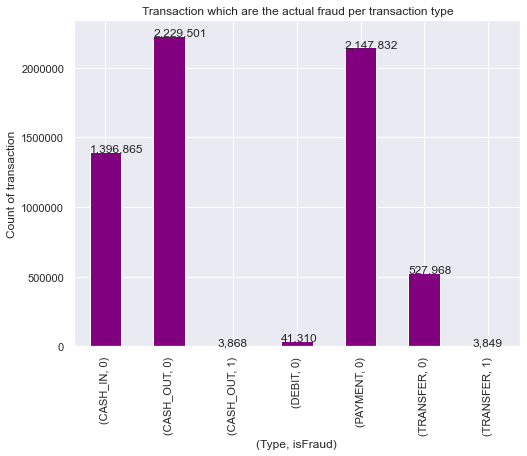

In [19]:
ax = df.groupby(['type', 'isFraud']).size().plot(kind='bar',figsize=(8, 6), color='purple')
ax.set_title(" Transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Type, isFraud)")
ax.set_ylabel("Count of transaction")
plt.ticklabel_format(style='plain', axis='y')
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))


C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


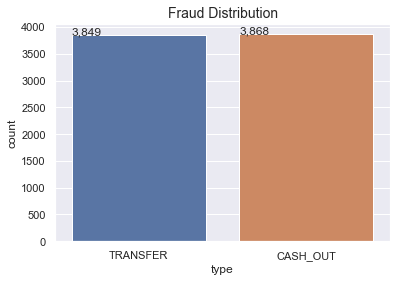

In [20]:
ax=sns.countplot('type', data=f_df)
plt.title('Fraud Distribution', fontsize=14)
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))

plt.show()

From the above graph we can see that the Fraudulent transafers are from CASH_OUT(4116) and TRANSFER(4097) , transaction types

In [21]:
# ax = df.groupby(['type', 'isFlaggedFraud']).size().plot(kind='bar',figsize=(8, 6), color='pink')
# ax.set_title("Transaction which are flagged as fraud per transaction type")
# ax.set_xlabel("(Type, isFlaggedFraud)")
# ax.set_ylabel("Count of transaction")
# for p in ax.patches:
#     ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

From the above graph we can see that the transfers that are Flagged Fraud are from TRANSFER(16) transaction type.
So out of 4097 Fraud Transfers only 16 were flagged by the system.

So, only 16 out of 6 million transactions were flagged by the system. It is safe to say the system uses an unreasonable parameter to detect fraud transactions

Conclusion: Although isFraud is always set when isFlaggedFraud is set, since isFlaggedFraud is set just 16 times in a seemingly meaningless way, we can treat this feature as insignificant and discard it in the dataset without loosing information.

### Dealing with Account Ids 'nameOrig' and 'nameDest'

In [22]:
print('All Transactions ',df['nameOrig'].size)
print('Unique Transactions ',df['nameOrig'].unique().size)
print('Transactions from existing accounts ',df['nameOrig'].size-df['nameOrig'].unique().size)


All Transactions  6351193
Unique Transactions  6341907
Transactions from existing accounts  9286


In [23]:
print('All Transactions ',df['nameDest'].size)
print('Unique Transactions ',df['nameDest'].unique().size)
print('Transactions from existing accounts ',df['nameDest'].size-df['nameOrig'].unique().size)


All Transactions  6351193
Unique Transactions  2716810
Transactions from existing accounts  9286


In [24]:
print('\nAre there any merchants among originator accounts for CASH_IN \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M')).any()))


Are there any merchants among originator accounts for CASH_IN transactions? False


In [25]:
print('\nAre there any merchants among destination accounts for CASH_OUT \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_OUT'].nameDest.str.contains('M')).any()))


Are there any merchants among destination accounts for CASH_OUT transactions? False


Merchant accounts are not included in the  fraudulent Transactions. Merchant accounts were only identified in 'Payment' type transactions

Conclusion: We do not get any benificial information from the nameOrig or nameDest, so we'll be dropping these columns

## Feature Engineering and Data Cleaning 

From the exploratory data analysis (EDA), we know that fraud only occurs in 'TRANSFER's and 'CASH_OUT's. So we assemble only the corresponding data in X for analysis.

In [27]:
# Eliminate columns shown to be irrelevant for analysis in the EDA
# df = df.drop(['nameOrig', 'nameDest'], axis = 1)


In [28]:
df.head()

step      type    amount     nameOrig  oldbalanceOrig  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  
0  M1979787155             0.0             0.0        0  
1  M2044282225             0.0             0.0        0  
2   C553264065             0.0             0.0        1  
3    C38997010         21182.0             0.0        1  
4  M1230701703             0.0             0.0        0

In [29]:
df_new = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)
df_new

step      type      amount     nameOrig  oldbalanceOrig  \
2           1  TRANSFER      181.00  C1305486145          181.00   
3           1  CASH_OUT      181.00   C840083671          181.00   
15          1  CASH_OUT   229133.94   C905080434        15325.00   
19          1  TRANSFER   215310.30  C1670993182          705.00   
24          1  TRANSFER   311685.89  C1984094095        10835.00   
...       ...       ...         ...          ...             ...   
6351186   699  CASH_OUT    62372.43  C1915659563        62372.43   
6351188   699  TRANSFER   162326.52  C1557504343       162326.52   
6351189   699  CASH_OUT   162326.52  C1532317723       162326.52   
6351190   699  TRANSFER  2763398.31   C577803442      2763398.31   
6351191   699  CASH_OUT  2763398.31  C1491503658      2763398.31   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  
2                   0.0   C553264065            0.00            0.00        1  
3                   0.0    C38997010        21182.00            0.00        1  
15                  0.0   C476402209         5083.00        51513.44        0  
19                  0.0  C1100439041        22425.00            0.00        0  
24                  0.0   C932583850         6267.00      2719172.89        0  
...                 ...          ...             ...             ...      ...  
6351186             0.0   C421781202      1195387.47      1257759.90        1  
6351188             0.0   C404511346            0.00            0.00        1  
6351189             0.0   C446134087            0.00       162326.52        1  
6351190             0.0   C619602282            0.00            0.00        1  
6351191             0.0   C454424230       339515.35      3102913.66        1  

[2765186 rows x 10 columns]

### Taking note of the balances before and after transactions 

As most of the transactions has errors in showing the account balances before and after transaction , we calculate the error

In [30]:
wrong_orig_bal = sum(df["oldbalanceOrig"] - df["amount"] != df["newbalanceOrig"])
wrong_dest_bal = sum(df["newbalanceDest"] + df["amount"] != df["newbalanceDest"])
print("Percentage of observations with balance errors in the account giving money: ", 100*round(wrong_orig_bal/len(df),2))
print("Percentage of observations with balance errors in the account receiving money: ", 100*round(wrong_dest_bal/len(df),2))

Percentage of observations with balance errors in the account giving money:  85.0
Percentage of observations with balance errors in the account receiving money:  100.0


In [32]:
df_new["errorbalanceOrig"] = df_new.newbalanceOrig + df_new.amount - df_new.oldbalanceOrig
df_new["errorbalanceDest"] = df_new.oldbalanceDest + df_new.amount - df_new.newbalanceDest

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [33]:
# Subsetting data into observations with fraud and valid transactions:
fraud = df_new[df_new["isFraud"] == 1]
valid = df_new[df_new["isFraud"] == 0]

In [34]:
print("Proportion of fraudulent transactions with errorBalanceDest > 0: ", len(fraud[fraud.errorbalanceDest > 0])/len(fraud))
print("Proportion of valid transactions with errorBalanceDest > 0: ", len(valid[valid.errorbalanceDest > 0])/len(valid))
print("Proportion of fraudulent transactions with errorBalanceOrig > 0: ", len(fraud[fraud.errorbalanceOrig > 0])/len(fraud))
print("Proportion of valid transactions with errorBalanceOrig > 0: ", len(valid[valid.errorbalanceOrig > 0])/len(valid))

Proportion of fraudulent transactions with errorBalanceDest > 0:  0.5717247635091357
Proportion of valid transactions with errorBalanceDest > 0:  0.1975173610292627
Proportion of fraudulent transactions with errorBalanceOrig > 0:  0.006220033691849165
Proportion of valid transactions with errorBalanceOrig > 0:  0.9068004028331779


Conclusions:
1. Most of the transactions where errorbalanceDest > 0 has high chance of being fraud
2. Valid transactions are most likely to have errorbalanceOrig > 0 

### Taking note of the Step feature

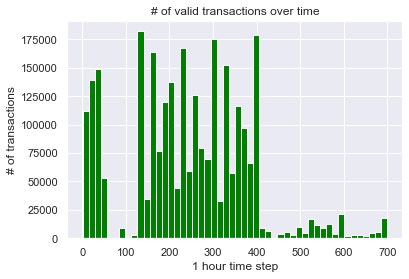

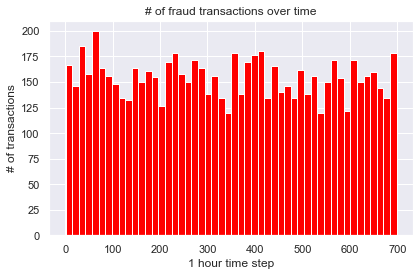

In [35]:
# Time patterns

bins = 50

valid.hist(column="step",color="green",bins=bins)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of valid transactions over time")

fraud.hist(column ="step",color="red",bins=bins)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of fraud transactions over time")

plt.tight_layout()
plt.show()


Things to note:
1. A lot of Valid transactions occur during 0 to 60 hours and then again 120 to 400 hrs
2. The fraud transactions dont change much throughout the time frame

####  Converting the step feature from hours into days

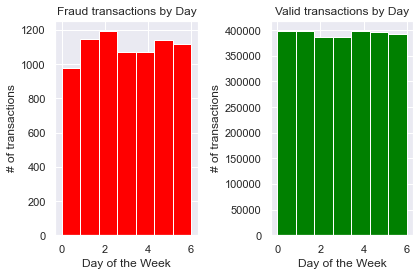

In [36]:
num_days = 7
num_hours = 24
fraud_days = fraud.step % num_days
fraud_hours = fraud.step % num_hours
valid_days = valid.step % num_days
valid_hours = valid.step % num_hours

# plotting scatterplot of the days of the week, identifying the fraudulent transactions (red) from the valid transactions (green) 
plt.subplot(1, 2, 1)
fraud_days.hist(bins=num_days,color="red")
plt.title('Fraud transactions by Day')
plt.xlabel('Day of the Week')
plt.ylabel("# of transactions")

plt.subplot(1,2,2)
valid_days.hist(bins=num_days,color="green")
plt.title('Valid transactions by Day')
plt.xlabel('Day of the Week')
plt.ylabel("# of transactions")

plt.tight_layout()
plt.show()

The distribution of fraud and valid dont show much of differnce to work with so I won't add this as a feature 

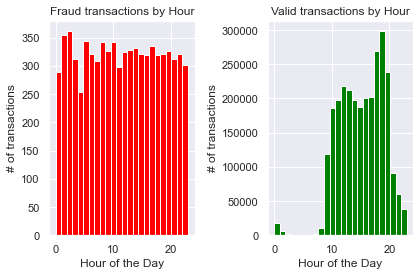

In [37]:
# plotting scatterplot of the hours of days, identifying the fraudulent transactions (red) from the valid transactions (green) 
plt.subplot(1, 2, 1)
fraud_hours.hist(bins=num_hours, color="red")
plt.title('Fraud transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel("# of transactions")


plt.subplot(1, 2, 2)
valid_hours.hist(bins=num_hours, color="green")
plt.title('Valid transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel("# of transactions")

plt.tight_layout()
plt.show()

From the graphs above, there is strong evidence to suggest that from hour 0 to hour 9, valid transactions very rarely occur. On the other hand, fraudulent transactions still occur at similar rates to any hour of the day outside of hours 0 to 9.

So I will add a new feature hour_of_day which is just the [(step column) %24]

In [38]:
dataset = df_new.copy()


# adding feature HourOfDay to Dataset1 
# dataset["HourOfDay"] = np.nan # initializing feature column
# dataset.HourOfDay = df_new.step % 24


print("Head of dataset1: \n", pd.DataFrame.head(dataset))

Head of dataset1: 
     step      type     amount     nameOrig  oldbalanceOrig  newbalanceOrig  \
2      1  TRANSFER     181.00  C1305486145           181.0             0.0   
3      1  CASH_OUT     181.00   C840083671           181.0             0.0   
15     1  CASH_OUT  229133.94   C905080434         15325.0             0.0   
19     1  TRANSFER  215310.30  C1670993182           705.0             0.0   
24     1  TRANSFER  311685.89  C1984094095         10835.0             0.0   

       nameDest  oldbalanceDest  newbalanceDest  isFraud  errorbalanceOrig  \
2    C553264065             0.0            0.00        1              0.00   
3     C38997010         21182.0            0.00        1              0.00   
15   C476402209          5083.0        51513.44        0         213808.94   
19  C1100439041         22425.0            0.00        0         214605.30   
24   C932583850          6267.0      2719172.89        0         300850.89   

    errorbalanceDest  
2              181.

### Taking note of amount column 

In [67]:
print('CASE AMOUNT STATISTICS')
print('\nNON-FRAUD CASE AMOUNT STATS')
print(valid['amount'].describe())
print('\nFRAUD CASE AMOUNT STATS')
print(fraud['amount'].describe())

CASE AMOUNT STATISTICS

NON-FRAUD CASE AMOUNT STATS
count    2.757469e+06
mean     3.142777e+05
std      8.778350e+05
min      1.000000e-02
25%      8.291251e+04
50%      1.710510e+05
75%      3.060316e+05
max      9.244552e+07
Name: amount, dtype: float64

FRAUD CASE AMOUNT STATS
count    7.717000e+03
mean     1.449185e+06
std      2.364817e+06
min      0.000000e+00
25%      1.271565e+05
50%      4.438937e+05
75%      1.506795e+06
max      1.000000e+07
Name: amount, dtype: float64


It seems that during fraudulent transactions, the amount moved is capped at 10 million currency units.

Whereas for valid transactions, the amount moved is capped at about 92.4 million currency units.

Only valid transaction involved amounts larger than 10,000,000, however these transactions make up less than 0.01% of the relevant data.

When the amounts moved is less than 10,000,000 there doesn't seem to be a large difference fraudulent and valid transactions.

I leave the variable amount as it is and will not be creating a feature out of it.

In [40]:
dataset.head()

step      type     amount     nameOrig  oldbalanceOrig  newbalanceOrig  \
2      1  TRANSFER     181.00  C1305486145           181.0             0.0   
3      1  CASH_OUT     181.00   C840083671           181.0             0.0   
15     1  CASH_OUT  229133.94   C905080434         15325.0             0.0   
19     1  TRANSFER  215310.30  C1670993182           705.0             0.0   
24     1  TRANSFER  311685.89  C1984094095         10835.0             0.0   

       nameDest  oldbalanceDest  newbalanceDest  isFraud  errorbalanceOrig  \
2    C553264065             0.0            0.00        1              0.00   
3     C38997010         21182.0            0.00        1              0.00   
15   C476402209          5083.0        51513.44        0         213808.94   
19  C1100439041         22425.0            0.00        0         214605.30   
24   C932583850          6267.0      2719172.89        0         300850.89   

    errorbalanceDest  
2              181.0  
3            21363.0  
15          182703.5  
19          237735.3  
24        -2401220.0

### Handling Categorical Variables 

We will perfrom one-hot-encoding on the 'type' column which is a categorical feature

One-Hot encoding involves creating indicator variables for each category in a categorical variable.

If an observation is part of a particular category (e.g. the transaction type is CASH_OUT), the indicator variable associated with the category would be 1. If it isn't part of a particular category, then the indicator variable associated with that category would be 0.

In [41]:
dataset.type.value_counts()

CASH_OUT    2233369
TRANSFER     531817
Name: type, dtype: int64

In [42]:
label_encoder = LabelEncoder()
dataset['type']= label_encoder.fit_transform(dataset['type'])

dataset['type']
# dataset = pd.get_dummies(dataset,prefix=['Transfer', 'Cash out'])

2          1
3          0
15         0
19         1
24         1
          ..
6351186    0
6351188    1
6351189    0
6351190    1
6351191    0
Name: type, Length: 2765186, dtype: int32

In [43]:
dataset = dataset.drop(['nameOrig', 'nameDest'], axis = 1)


In [44]:
dataset

step  type      amount  oldbalanceOrig  newbalanceOrig  \
2           1     1      181.00          181.00             0.0   
3           1     0      181.00          181.00             0.0   
15          1     0   229133.94        15325.00             0.0   
19          1     1   215310.30          705.00             0.0   
24          1     1   311685.89        10835.00             0.0   
...       ...   ...         ...             ...             ...   
6351186   699     0    62372.43        62372.43             0.0   
6351188   699     1   162326.52       162326.52             0.0   
6351189   699     0   162326.52       162326.52             0.0   
6351190   699     1  2763398.31      2763398.31             0.0   
6351191   699     0  2763398.31      2763398.31             0.0   

         oldbalanceDest  newbalanceDest  isFraud  errorbalanceOrig  \
2                  0.00            0.00        1              0.00   
3              21182.00            0.00        1              0.00   
15              5083.00        51513.44        0         213808.94   
19             22425.00            0.00        0         214605.30   
24              6267.00      2719172.89        0         300850.89   
...                 ...             ...      ...               ...   
6351186      1195387.47      1257759.90        1              0.00   
6351188            0.00            0.00        1              0.00   
6351189            0.00       162326.52        1              0.00   
6351190            0.00            0.00        1              0.00   
6351191       339515.35      3102913.66        1              0.00   

         errorbalanceDest  
2                  181.00  
3                21363.00  
15              182703.50  
19              237735.30  
24            -2401220.00  
...                   ...  
6351186              0.00  
6351188         162326.52  
6351189              0.00  
6351190        2763398.31  
6351191              0.00  

[2765186 rows x 10 columns]

In [45]:
seed(21)

X = dataset.drop("isFraud",1)
Y = dataset.isFraud
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

# Normalizing data so that all variables follow the same scale (0 to 1)
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


<ipython-input-45-eb02f06b1895>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = dataset.drop("isFraud",1)


In [46]:
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (2212148, 9)
Shape of X_test:  (553038, 9)


## Model Selection 

In [47]:
print('fruad ',fraud.shape)
print('Valid', valid.shape)


fruad  (7717, 12)
Valid (2757469, 12)


The data is extremely skewed, so we will test the models on unbalanced datd first and then perform Resampling technique to make it a balanced dataset

### Model 1: Random Forest

In [49]:
# Train model
parametersRF = {'n_estimators':15,'class_weight': "balanced",'n_jobs':-1,'random_state':42}
RF = RandomForestClassifier(**parametersRF)
fitted_vals = RF.fit(X_train, y_train)
 

# Predict on testing set
predictionsRF = RF.predict(X_test)


In [50]:
     
# Evaluating model
CM_RF = confusion_matrix(y_test,predictionsRF)
CR_RF = classification_report(y_test,predictionsRF)
fprRF, recallRF, thresholdsRF = roc_curve(y_test, predictionsRF)
AUC_RF = auc(fprRF, recallRF)

resultsRF = {"Confusion Matrix":CM_RF,"Classification Report":CR_RF,"Area Under Curve":AUC_RF}

# showing results from Random Forest

for measure in resultsRF:
    print(measure,": \n",resultsRF[measure])

Confusion Matrix : 
 [[551524      0]
 [     7   1507]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    551524
           1       1.00      1.00      1.00      1514

    accuracy                           1.00    553038
   macro avg       1.00      1.00      1.00    553038
weighted avg       1.00      1.00      1.00    553038

Area Under Curve : 
 0.9976882430647291


### Model 2: Decision Tree 

In [51]:
# Train model
DT = DecisionTreeClassifier()
fitted_vals = DT.fit(X_train, y_train)
 
# Predict on testing set
predictionsDT = DT.predict(X_test)
 
     
# Evaluating model
CM_DT = confusion_matrix(y_test,predictionsDT)
CR_DT = classification_report(y_test,predictionsDT)
fprDT, recallDT, thresholdsDT = roc_curve(y_test, predictionsDT)
AUC_DT = auc(fprDT, recallDT)

resultsDT = {"Confusion Matrix":CM_DT,"Classification Report":CR_DT,"Area Under Curve":AUC_DT}

# showing results from Random Forest

for measure in resultsDT:
    print(measure,": \n",resultsDT[measure])

Confusion Matrix : 
 [[551515      9]
 [     6   1508]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    551524
           1       0.99      1.00      1.00      1514

    accuracy                           1.00    553038
   macro avg       1.00      1.00      1.00    553038
weighted avg       1.00      1.00      1.00    553038

Area Under Curve : 
 0.9980103348457289


Decision trees are an effective model for binary classification tasks, although by default, they are not effective at imbalanced classification.

### Model 3: XGBoost Classifier 

In [52]:
# Train model
parametersXGB = {'max_depth':3,'class_weight': "balanced",'n_jobs':-1,'random_state':42,'learning_rate':0.1}
XGB = XGBClassifier(**parametersXGB)
    
    
fitted_vals = XGB.fit(X_train, y_train)
 
# Predict on testing set
predictionsXGB = XGB.predict(X_test)
 
     
# Evaluating model
CM_XGB = confusion_matrix(y_test,predictionsXGB)
CR_XGB = classification_report(y_test,predictionsXGB)
fprXGB, recallXGB, thresholds_XGB = roc_curve(y_test, predictionsXGB)
AUC_XGB = auc(fprXGB, recallXGB)
resultsXGB = {"Confusion Matrix":CM_XGB,"Classification Report":CR_XGB,"Area Under Curve":AUC_XGB}
# showing results from Extreme Gradient Boosting
for measure in resultsXGB:
    print(measure,": \n",resultsXGB[measure],"\n")

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:57:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:57:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix : 
 [[551524      0]
 [     8   1506]] 

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    551524
           1       1.00      0.99      1.00      1514

    accuracy                           1.00    55303

## Comparing the models: Unbalanced data

In [53]:
print("Note: scores in the same vertical level as 0 are scores for valid transactions. \n \
      Scores in the same vertical level as 1 are scores for fraudulent transactions. \n")
print("Classification Report of Random Forest: \n", CR_RF)
print("Classification Report of Decision trees: \n", CR_DT)
print("Classification Report of XGB trees: \n", CR_XGB)


Note: scores in the same vertical level as 0 are scores for valid transactions. 
       Scores in the same vertical level as 1 are scores for fraudulent transactions. 

Classification Report of Random Forest: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    551524
           1       1.00      1.00      1.00      1514

    accuracy                           1.00    553038
   macro avg       1.00      1.00      1.00    553038
weighted avg       1.00      1.00      1.00    553038

Classification Report of Decision trees: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    551524
           1       0.99      1.00      1.00      1514

    accuracy                           1.00    553038
   macro avg       1.00      1.00      1.00    553038
weighted avg       1.00      1.00      1.00    553038

Classification Report of XGB trees: 
               precision    recall  f1-score   support


From the results , Decision Tree and Random Forest has the better results but since the data is heavily skewed we need to handle the datasets to yield better results. 

## Handling Imbalanced Data


We will use undersampling when we have huge data and undersampling the majority call won't effect the data. 

In [54]:

# check version number
import imblearn
print(imblearn.__version__)
# check version number
import imblearn
print(imblearn.__version__)

0.8.0
0.8.0


In [55]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler 
rus = RandomUnderSampler(random_state=42)
X_resampled, Y_resampled = rus.fit_resample(X, Y)
print("Resampled shape of X: ", X_resampled.shape)
print("Resampled shape of Y: ", Y_resampled.shape)
value_counts = Counter(Y_resampled)
print(value_counts)
train_X, test_X, train_Y, test_Y = train_test_split(X_resampled, Y_resampled, test_size= 0.3, random_state= 42)                              
                              

Resampled shape of X:  (15434, 9)
Resampled shape of Y:  (15434,)
Counter({0: 7717, 1: 7717})


### Model 1: Random Forest: Balanced Data

In [56]:
# Train model
parametersRF = {'n_estimators':15,'n_jobs':-1,'random_state':42}
RF = RandomForestClassifier(**parametersRF)
fitted_vals = RF.fit(train_X, train_Y)
 
# Predict on testing set
predictionsRF = RF.predict(test_X)
 
     
# Evaluating model
CM_RF = confusion_matrix(test_Y,predictionsRF)
CR_RF = classification_report(test_Y,predictionsRF)
fprRF, recallRF, thresholdsRF = roc_curve(test_Y, predictionsRF)
AUC_RF = auc(fprRF, recallRF)

resultsRF = {"Confusion Matrix":CM_RF,"Classification Report":CR_RF,"Area Under Curve":AUC_RF}

# showing results from Random Forest

for measure in resultsRF:
    print(measure,": \n",resultsRF[measure])

Confusion Matrix : 
 [[2322    1]
 [   9 2299]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2323
           1       1.00      1.00      1.00      2308

    accuracy                           1.00      4631
   macro avg       1.00      1.00      1.00      4631
weighted avg       1.00      1.00      1.00      4631

Area Under Curve : 
 0.9978350210501421


### Model 2: Decision Tree Classifier: Balanced Data 

In [57]:
X_test 

array([[-0.22156867, -0.48829646, -0.27730192, ..., -0.42885588,
        -0.25735853,  0.04898688],
       [ 0.64808281,  2.04793622,  0.99552325, ...,  0.43236803,
         1.04408121,  0.04898688],
       [-1.45476298, -0.48829646, -0.00674141, ...,  0.42095567,
         0.02869973, -0.37960888],
       ...,
       [ 0.81203349, -0.48829646, -0.24042502, ..., -0.39313147,
        -0.20804214,  0.29399496],
       [-0.25721013, -0.48829646,  0.02993887, ...,  0.09774735,
         0.05441786,  0.04898688],
       [ 2.99329048, -0.48829646, -0.08720526, ..., -0.38644743,
        -0.07075588,  0.04898688]])

In [58]:
# Train model
DT = DecisionTreeClassifier()
fitted_vals = DT.fit(X_train, y_train)
 
# Predict on testing set
predictionsDT = DT.predict(X_test)

    
# Evaluating model
CM_DT = confusion_matrix(y_test,predictionsDT)
CR_DT = classification_report(y_test,predictionsDT)
fprDT, recallDT, thresholdsDT = roc_curve(y_test, predictionsDT)
AUC_DT = auc(fprDT, recallDT)

resultsDT = {"Confusion Matrix":CM_DT,"Classification Report":CR_DT,"Area Under Curve":AUC_DT}

# showing results from Random Forest

for measure in resultsDT:
    print(measure,": \n",resultsDT[measure])

Confusion Matrix : 
 [[551516      8]
 [     6   1508]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    551524
           1       0.99      1.00      1.00      1514

    accuracy                           1.00    553038
   macro avg       1.00      1.00      1.00    553038
weighted avg       1.00      1.00      1.00    553038

Area Under Curve : 
 0.9980112414245903


###  XGBoost Classifier: Balanced Data

In [59]:
# Train model
parametersXGB = {'max_depth':3,'class_weight': "balanced",'n_jobs':-1,'random_state':42,'learning_rate':0.1}
XGB = XGBClassifier(**parametersXGB)
    
    
fitted_vals = XGB.fit(X_train, y_train)
 
# Predict on testing set
predictionsXGB = XGB.predict(X_test)
 
     
# Evaluating model
CM_XGB = confusion_matrix(y_test,predictionsXGB)
CR_XGB = classification_report(y_test,predictionsXGB)
fprXGB, recallXGB, thresholds_XGB = roc_curve(y_test, predictionsXGB)
AUC_XGB = auc(fprXGB, recallXGB)
resultsXGB = {"Confusion Matrix":CM_XGB,"Classification Report":CR_XGB,"Area Under Curve":AUC_XGB}
# showing results from Extreme Gradient Boosting
for measure in resultsXGB:
    print(measure,": \n",resultsXGB[measure],"\n")

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:01:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:01:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix : 
 [[551524      0]
 [     8   1506]] 

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    551524
           1       1.00      0.99      1.00      1514

    accuracy                           1.00    55303

## Comparing the models: Balanced data 

In [60]:
print("Note: scores in the same vertical level as 0 are scores for valid transactions. \n \
      Scores in the same vertical level as 1 are scores for fraudulent transactions. \n")
print("Classification Report of Random Forest: \n", CR_RF)
print("Classification Report of Decision trees: \n", CR_DT)
print("Classification Report of XGB trees: \n", CR_XGB)


Note: scores in the same vertical level as 0 are scores for valid transactions. 
       Scores in the same vertical level as 1 are scores for fraudulent transactions. 

Classification Report of Random Forest: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2323
           1       1.00      1.00      1.00      2308

    accuracy                           1.00      4631
   macro avg       1.00      1.00      1.00      4631
weighted avg       1.00      1.00      1.00      4631

Classification Report of Decision trees: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    551524
           1       0.99      1.00      1.00      1514

    accuracy                           1.00    553038
   macro avg       1.00      1.00      1.00    553038
weighted avg       1.00      1.00      1.00    553038

Classification Report of XGB trees: 
               precision    recall  f1-score   support


In [61]:
print("Number of valid transactions labelled as fraudulent by Random Forest: \n", CM_RF[0,1])
print("Number of valid transactions labelled as fraudulent by XGB trees: \n", CM_XGB[0,1])
print("Number of valid transactions labelled as fraudulent by Decision Tree: \n", CM_DT[0,1])

Number of valid transactions labelled as fraudulent by Random Forest: 
 1
Number of valid transactions labelled as fraudulent by XGB trees: 
 0
Number of valid transactions labelled as fraudulent by Decision Tree: 
 8


In [62]:
print("Number of fraud transactions labelled as valid by Random Forest: \n", CM_RF[1,0])
print("Number of fraud transactions labelled as valid by XGB trees: \n", CM_XGB[1,0])
print("Number of fraud transactions labelled as valid by Decision Tree: \n", CM_DT[1,0])

Number of fraud transactions labelled as valid by Random Forest: 
 9
Number of fraud transactions labelled as valid by XGB trees: 
 8
Number of fraud transactions labelled as valid by Decision Tree: 
 6


Interestingly, even though XGBoost predicts no valid data as fraudulent but has a huge error in predicting the fraud transactions which is our aim here.

So we will prefer Random Forest from this metric

In [63]:
print("\nAUC of Random Forest: \n", AUC_RF)
print("\nAUC of Decision Tree: \n", AUC_DT)
print("\nAUC of XGB trees: \n", AUC_XGB)


AUC of Random Forest: 
 0.9978350210501421

AUC of Decision Tree: 
 0.9980112414245903

AUC of XGB trees: 
 0.9973579920739762


 
What does the Area under Curve tells us ?
Area Under Curve is a plot of the true positive rates (in our case, the proportion of valid transactions labelled as valid) against the false positive rate (in our case, the proportion of fraudulent transactions labelled as valid). The curve is also known as the Receiver Operating Characteristic Curve or ROC.

The ideal AUC is then 1 (all transactions predicted as valid are actually valid).

From the above results:
#### Random Forest 
has the Area under Curve closest to 1, so I can confidently say that Random forest is the right model in this scenario.

## Important Features 

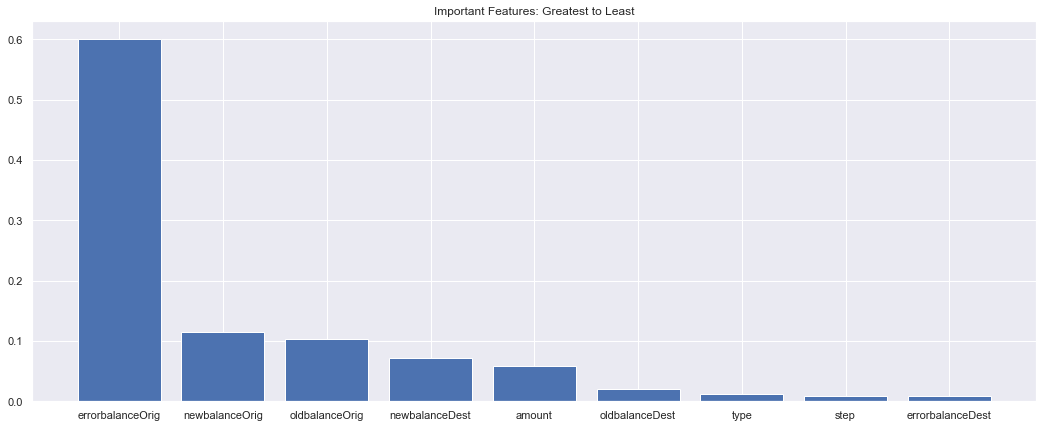

In [64]:
ncols = len(X.columns)
x = np.arange(ncols)

# getting importances of features
importances = RF.feature_importances_

# getting the indices of the most important feature to least important
sort_ind = np.argsort(importances)[::-1]
plt.figure(figsize=(18,7))
plt.bar(x, importances[sort_ind])
plt.xticks(x,tuple(X.columns.values[sort_ind]))
plt.title("Important Features: Greatest to Least")
plt.show()

errorBalanceOrg is the most important feature by far for classifying transactions followed by oldBalanceOrg and newBalanceOrig.

## Conclusion 

1. The dataset is huge with over million data points, and the ratio of fraud to valid data is heavily skewed towads valid data
2. Feature engineering and creation of two new features namely 'errorbalance' and 'HourofDay' yielded fruitful results.
3. XGboost is the best model in the given situation as it is fairly accurate in predicting both fraud and valid data, and has the heigest AUC .
4. Working with such a large dataset is always a challenge and this helped me learn a lot .

Thank You!